In [1]:
import os
from dotenv import load_dotenv
load_dotenv()


GOOGLE_API_KEY=os.getenv("GOOGLE_API_KEY")
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGCHAIN_PROJECT=os.getenv("LANGCHAIN_PROJECT")


os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["GROQ_API_KEY"]= GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]=LANGCHAIN_PROJECT

In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

/home/ravi0531rp/anaconda3/envs/langGraph-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langgraph.graph import Graph
from IPython.display import Image, display
def vizualize(app):
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        # This requires some extra dependencies and is optional
        print(e)

In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [5]:
loader=DirectoryLoader("./",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [7]:
doc_strings[:3]

['Don’t be fooled by me throwing around the word “self-attention” like it’s a concept everyone should',
 'like it’s a concept everyone should be familiar with. I had personally never came across the',
 'with. I had personally never came across the concept until reading the Attention is All You Need']

In [8]:
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [10]:
query = "what does self attention do?"
docs = retriever.invoke(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': 'data.txt'}
Don’t be fooled by me throwing around the word “self-attention” like it’s a concept everyone should
page_content='Don’t be fooled by me throwing around the word “self-attention” like it’s a concept everyone should' metadata={'source': 'data.txt'}
page_content='the input sequence), self attention allows it to look at other positions in the input sequence for' metadata={'source': 'data.txt'}
page_content='processed with the current one it’s processing. Self-attention is the method the Transformer uses' metadata={'source': 'data.txt'}


In [11]:
def function_1(AgentState):
    
    message=AgentState["messages"]
    
    question=message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
        
    return AgentState

In [12]:
AgentState={}


In [13]:
AgentState["messages"]=[]


In [14]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [16]:
# Define a Langchain graph
from langgraph.graph import Graph
workflow4 = Graph()
workflow4.add_node("LLM", function_1)
workflow4.add_node("RAGtool", function_2)
workflow4.add_edge('LLM', 'RAGtool')
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAGtool")
app = workflow4.compile()

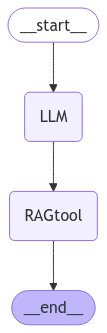

In [17]:
vizualize(app)

In [18]:
inputs = {"messages": ["Tell me about attention"]}
for output in app.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")


Output from node 'LLM':
---
{'messages': ['Tell me about attention', 'Attention is a cognitive process of selectively concentrating on one aspect of the environment while ignoring others.\n']}

---

Output from node 'RAGtool':
---
Based on the provided text, the concept of "self-attention" is mentioned, but it's described as something not universally known.  The text indicates the author encountered it while reading the "Attention is All You Need" paper.  No further details about attention are given.


---

